In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0. Requirements

In [ ]:
!pip install simpleaudio
!pip install ipapy
!pip install torchaudio
!pip3 install nfnets-pytorch
!pip install git+https://github.com/benjs/nfnets_pytorch
!pip install audiomentations

In [ ]:
# Torch
import torch
import torchaudio as ta
import torch.nn.functional as F
import torchvision as tv

# Math
import numpy as np
import math
import random

# Data Augmentation
import audiomentations

# Librosa
import librosa

# NF-nets
from nfnets import WSConv2D
from nfnets import pretrained_nfnet
import nfnets

# Utils
import os
import matplotlib.pyplot as plt
import copy
from tqdm.notebook import tqdm, trange
from IPython.display import Audio
from IPython.core.display import display

# IPAPY
import ipapy
from ipapy import UNICODE_TO_IPA
from ipapy import is_valid_ipa
from ipapy.ipachar import IPAConsonant
from ipapy.ipachar import IPAVowel
from ipapy.ipastring import IPAString


In [ ]:
path = './drive/MyDrive/data/'
os.chdir(path)

# 1. Datasets and DataLoaders

## AudioFolder + Loaded + SelectedSubset (and Transforms)

In [ ]:
tr = torch.nn.Sequential(
    ta.transforms.MelSpectrogram(n_fft=600, n_mels=128, win_length=200),
    ta.transforms.AmplitudeToDB(),
)

In [ ]:
class AudioFolder(torch.utils.data.Dataset):
  def __init__(self, path, tr, pad_to=161):
    super(AudioFolder, self).__init__()
    self.path = path
    self.classes_names = sorted(os.listdir(path))
    self.tr   = tr

    self.files = sum([[path+n+'/'+f for f in sorted(os.listdir(path+n))] for n in self.classes_names], [])
    self.classes = torch.cat([i*torch.ones(len(os.listdir(path+n))) for i,n in enumerate(self.classes_names)])

    self.len = len(self.files)

    self.pad_to = pad_to

  def __getitem__(self, idx):

    # Index
    loaded = ta.load(self.files[idx])[0]
    assert loaded.shape[0] == 1

    # Transforming
    transformed = self.tr(loaded)

    # Padding
    n = transformed.shape[2]
    right = (self.pad_to-n)//2
    left = self.pad_to - n - right
    padded = F.pad(transformed, (right, left), mode='reflect').squeeze(0)

    return padded, self.classes[idx]

  def __len__(self):
    return self.len

In [ ]:
class LoadedDataset(torch.utils.data.Dataset):
  def __init__(self, ds):

    # Loading
    print("Preparing...")
    dl = torch.utils.data.DataLoader(ds, batch_size=512)

    print("Loading...")
    Xs, ys = [], []
    
    for X,y in tqdm(dl):
      Xs.append(X)
      ys.append(y)
    print("Loaded!")

    # Connect
    self.X = torch.cat(Xs)
    self.y = torch.cat(ys)

    # Params
    self.len = self.X.shape[0]

  def __len__(self):
    return self.len
    
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [ ]:
# ds = AudioFolder('./train/audio/', tr)
# lds = LoadedDataset(ds)
# torch.save(lds.X, './X.pkl')
# torch.save(lds.y, './y.pkl')

In [ ]:
class SavedDataset(torch.utils.data.Dataset):
  def __init__(self, path='./'):

    # Loading
    print("Loading...")
    self.X = torch.load(path + 'X.pkl').unsqueeze(1)
    self.y = torch.load(path + 'y.pkl')
    print("Loaded!")
    
    # Params
    self.len = self.X.shape[0]

  def __len__(self):
    return self.len
    
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [ ]:
# (sds.y == torch.Tensor([[4, 8, 11, 14, 15, 16, 18, 22, 26, 28]]).T).any(0)

In [ ]:
class SelectedClassesDataset(torch.utils.data.Dataset):
  def __init__(self, ds=None, cl=[4, 8, 11, 14, 15, 16, 18, 22, 26, 28], path='./'):
    super(SelectedClassesDataset, self).__init__()
    self.cl = cl
    if not ds:
      print("Loading...")
      self.X = torch.load(path + 'X.pkl').unsqueeze(1)
      self.y = torch.load(path + 'y.pkl')
      print("Loaded!")
    else:
      self.X = ds.X
      self.y = ds.y

    ind = (sds.y == torch.Tensor([cl]).T).any(0)
    
    self.X = self.X[ind]
    self.y = self.y[ind]

    self.len = self.X.shape[0]

  def __len__(self):
    return self.len
    
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [ ]:
class AllDataset(torch.utils.data.Dataset):
  def __init__(self, ss, ul, unknown_size=2000, silence_size=2000, path='./'):
    super(AllDataset, self).__init__()

    self.ss = ss
    self.ul = ul

    # Loading
    print("Loading...")
    self.X = torch.load(path + 'X.pkl').unsqueeze(1)
    self.y = torch.load(path + 'y.pkl').long()
    print("Loaded!")

    # Remap
    ind = [4, 8, 11, 14, 15, 16, 18, 22, 26, 28]
    j = 0
    new_class = []
    for i in range(30):
      if i in ind:
        new_class.append(j)
        j += 1
      else:
        new_class.append(11)

    for i in range(len(self.y)):
      self.y[i] = new_class[self.y[i]]

    # Add space
    self.silence_size = silence_size
    self.silence_start = self.X.shape[0]
    self.unknown_size = unknown_size
    self.unknown_start = self.silence_start + silence_size
    

    self.X = torch.cat([self.X, torch.zeros(unknown_size + silence_size, 1, 128, 161)])
    self.y = torch.cat([self.y,
                        10*torch.ones(silence_size).long(),
                        11*torch.ones(silence_size).long()]).long()

    # Silence:
    self.resample_silence()

    # Unknown Generated:
    self.resample_unknown()
    
    # Probabilities for sampling:
    self.prob = torch.ones_like(self.y).float()
    for i in range(12):
      self.prob[self.y == i] *= 1/12/(self.y == i).sum()
    
    # Params
    self.len = self.X.shape[0]

  def resample_silence(self):
    self.X[self.silence_start:self.silence_start+self.silence_size] = torch.cat([self.ss.sample() for _ in range(self.silence_size)]).unsqueeze(1)

  def resample_unknown(self):
    self.X[self.unknown_start:self.unknown_start+self.unknown_size] = torch.cat([self.ul.sample() for _ in range(self.unknown_size)]).unsqueeze(1)

  def __len__(self):
    return self.len
    
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

## Superme Dataset

In [ ]:
class UnknownSampler:
  def __init__(self):
    self.unknown_path = './train/unknown_pt/'
    self.seknown_path = './train/semiknown_pt/'

    self.unknown_files = os.listdir(self.unknown_path)
    self.seknown_files = os.listdir(self.seknown_path)

  def get_unknown(self, n=2380):
    unknowns = []
    for i in range(math.ceil(n/128)):
      unknowns.append(torch.load(self.unknown_path + random.choice(self.unknown_files)))
    # unknowns[-1] = unknowns[-1][0:n%128]
    return torch.cat(unknowns)[0:n].unsqueeze(1)

  def get_seknown(self, n=2380):
      seknown = []
      for i in range(math.ceil(n/2380)):
        seknown.append(torch.load(self.seknown_path + random.choice(self.seknown_files)))
      return torch.cat(seknown)[0:n]
  
  def sample(self, n=2380, mode='seknown'):
    if mode == 'seknown':
      return self.get_seknown(n)
    if mode == 'unknown':
      return self.get_unknown(n)
    if mode == 'mix':
      return torch.cat([self.get_seknown(n//2), self.get_unknown(n - n//2)]) 

In [ ]:
class SupremeDataset(torch.utils.data.Dataset):
  def __init__(self):
    super(SupremeDataset, self).__init__()
    self.X = torch.load('./XSU.pt')
    self.y = torch.load('./ySU.pt')

    # For resampling
    self.silence_ind = self.y == 10
    self.unknown_ind = self.y == 11
    
    # Silence
    self.ss = SilenceSampler()

    # Unknowns
    self.us = UnknownSampler()

    # Length
    self.len = self.X.shape[0]

  def resample_silence(self):
    self.X[self.silence_ind] = self.ss.sample(self.silence_ind.sum())

  def resample_unknown(self, mode='seknown'):
    self.X[self.unknown_ind] = self.us.sample(self.unknown_ind.sum(), mode)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]
  def __len__(self):
    return self.len

## PlayAudio Util

In [ ]:
class PlayAudio:
  def __init__(self):
    self.revtr = torch.nn.Sequential(
        ta.transforms.InverseMelScale(301, n_mels=128),
        ta.transforms.GriffinLim(n_fft=600, win_length=200)
    )
  def save_spect(self, path, sp):
    # ta.save(path, self.revtr((10**(sp/3)).sqrt()), sample_rate=16000)
    ta.save(path, self.revtr(librosa.db_to_amplitude(sp)), sample_rate=16000)
  def playsound(self, path):
    display(Audio(path, autoplay=True))
  def play_spect(self, sp):
    self.save_spect('./spect.wav', sp)
    self.playsound('./spect.wav')
PA = PlayAudio()

## Silence

In [ ]:
class SilenceSampler:
  def __init__(self,
               files=['./train/_background_noise_/' + s for s in os.listdir('./train/_background_noise_/') if '.wav' == s[-4:]],
               rng=range(-10, 10)):
    
    self.samples = [tr(ta.load(f)[0]) for f in files]
    for i in range(len(self.samples)):
      self.samples[i] = self.samples[i] - self.samples[i].mean() - 47
    self.range = rng

  def _sample(self):
    sample = random.choice(self.samples)
    pls    = random.choice(range(sample.shape[2] - 170))
    return sample[:,:,pls:pls+161] + random.choice(self.range)
  
  def sample(self, n=2380):
    return torch.cat([self._sample() for _ in range(n)]).unsqueeze(1)

In [ ]:
class SilenceGenerated:
  def __init__(self, files=None, batch_size=10, n=100, rng=range(-10, 10)):

    if files is None:
      files = ['./train/_background_noise_/' + s for s in os.listdir('./train/_background_noise_/') if '.wav' == s[-4:]]

    self.samples = [tr(ta.load(f)[0]) for f in files]
    for i in range(len(self.samples)):
      self.samples[i] = self.samples[i] - self.samples[i].mean() - 47
    self.range = rng
    self.n = n
    self.batch_size = batch_size

    self.resample()

  def __getitem__(self, ind):
    return self.gen[ind]
  def resample(self):
    self.gen = []
    for i in range(self.n):
      new = []
      for j in range(self.batch_size):
        sample = random.choice(self.samples)
        pls    = random.choice(range(sample.shape[2] - 170))
        new.append(sample[:,:,pls:pls+161] + random.choice(self.range))
      self.gen.append(torch.cat(new))

## RandomWordSampler 

In [ ]:
class RandomWordSampler():
  def __init__(self, ds, ss, words=None):
    """RandomWordSampler

    Args:
    * ds - dataset
    * class_names: list - phonetically, list of characters
    * words: list - words written phonetically, list of characters

    .sample()
    .sample_word([list of characters])
    """
    self.ds = ds
    self.class_names = [list(IPAString(unicode_string=e)) for e in """bɛd bɜːd kæt daʊn eɪt dɒg gəʊ faɪv ˈhæpi fɔː lɛft haʊs
                                                                      ɒf naɪn nəʊ marvin sɪks ˈʃiːlə wʌn raɪt ˈsɛvn ɒn θriː tuː
                                                                      stɒp triː ʌp jɛs waʊ ˈzɪərəʊ""".split()]
    if words:
      self.words = words
    else:
      self._get_words()

    # Letters
    self.letters = self._letters_from_dataset(
      self.class_names, # [list(s) for s in sorted(os.listdir('./train/audio'))[1:]],
      ds.X,
      ds.y
    )

    self.ss = ss

  def _move_n(self, im, n):
    return F.pad(im, [max(n,0), max(-n,0)], value=-60)[:,:,max(-n,0):im.shape[2]+abs(n)-max(n,0)]

  def _move_a2b(self, im, a, b):
    return self._move_n(im, b-a)
  
  def _apply_weight(self, im, place, weight):
    """
    weight has shape of 1,1,im.shape[2] * 2
    center of the weight is in the middle
    """
    return im * weight[:,:,im.shape[2]-place:2*im.shape[2]-place]
  
  def _mix(self, ims, wgs, pls, zero=-70):
    return sum([self._apply_weight(ims[i]-zero, pls[i], wgs[i]) for i in range(len(ims))])+zero

  def _move_mix(self, ims, wgs, pls, fin_pls, zero=-70):
    ims = [self._move_a2b(ims[i], pls[i], fin_pls[i]) for i in range(len(ims))]
    return self._mix(ims, wgs, fin_pls, zero)

  def _create_weights(self, ims):
    seq_len = ims[0].shape[2]
    width = seq_len // len(ims)
    
    wg = torch.Tensor([max(1-abs(i/width),0) for i in range(-seq_len, seq_len)]).unsqueeze(0).unsqueeze(0)
    first_wg = copy.deepcopy(wg)
    first_wg[:,:,:seq_len] = 1
    last_wg = copy.deepcopy(wg)
    last_wg[:,:,seq_len:] = 1

    return first_wg, wg, last_wg
  
  def _create(self, ims, pls, start, step, zero=-70):
  
    # Weights
    f, m, l = self._create_weights(ims)
    wgs = [f] + [m for i in range(len(ims)-2)] + [l]
    
    # Final Places
    fin_pls = [start + step//2 + step*i for i in range(len(ims))]

    assert all(fp < 161 for fp in fin_pls)

    return self._move_mix(ims, wgs, pls, fin_pls, zero=zero)

  def _find_range(self, img, pad=torch.Tensor([[-10],[20]])):
    f = img.mean(1).squeeze()
    fmin = f.min()
    fmax = f.max()
    try:
      return list(zip(*((f > 3*(fmax-fmin)/4 + fmin).nonzero()[[0,-1]] + pad).tolist()))[0]
    except Exception as e:
      print(e)
      return -1,-1

  def _get_letters_placement(self,p, q, length):
    step = (q - p) // length
    return [p + step//2 + step*i for i in range(length)]

  def _get_audio_info(self, word, im):
    p, q = self._find_range(im)
    lp = self._get_letters_placement(p, q, len(word))
    return list(zip(word,lp)), (p,q)
    
  def _get_class_info(self, word, X):
    pls, rs = list(zip(*[self._get_audio_info(word, X[i]) for i in range(X.shape[0])]))
    return pls, rs

  def _letters_from_class(self, word, X, ind):
    pls, rs = self._get_class_info(word, X[ind])
    letters = {w: [] for w in word}
    for i in range(len(ind)):
      for li, w in enumerate(word):
        assert pls[i][li][0] == w
        if pls[i][li][1] < 155:
          letters[w].append((ind[i], pls[i][li][1], rs[i], len(word)))
    return letters
  
  def _letters_from_dataset(self, class_names, X, y):
    letters = {s: [] for s in set(sum(class_names, []))}
    for i, cn in tqdm(enumerate(class_names)):
      l = self._letters_from_class(cn, X, torch.arange(y.shape[0])[y==i].tolist())
      for c in cn:
        letters[c] += l[c]
    return letters

  def _get_words(self):
    """
    Get words from the dataset, that have all sounds available.
    """

    class_names_pho = """bɛd bɜːd kæt daʊn eɪt dɒg gəʊ faɪv ˈhæpi fɔː lɛft haʊs
                         ɒf naɪn nəʊ marvin sɪks ˈʃiːlə wʌn raɪt ˈsɛvn ɒn θriː tuː
                         stɒp triː ʌp jɛs waʊ ˈzɪərəʊ""".replace('ː', '').split()
    available_sounds = set(list(IPAString(unicode_string=''.join(class_names_pho))))

    with open('./3000phonetic.txt', 'r') as f:
      words = f.read().replace(',', ' ').\
                       replace('ː', '').split()
    

    words = [w for w in words if is_valid_ipa(w)]
    words_IPA = [IPAString(unicode_string=e) for e in words if is_valid_ipa(e)]

    # words = [words[i] for i in range(len(words_IPA)) if len(set(list(words_IPA[i])).difference(available_sounds))==0]
    whole_words = [list(e) for e in words_IPA if len(set(list(e)).difference(available_sounds))==0]

    # words = [w for w in words if len(w)<8]
    whole_words = [w for w in whole_words if len(w) < 8]

    self.words = whole_words

  def sample_word(self, word):
    chosen = [random.choice(self.letters[w]) for w in word]

    sil   = self.ss.sample()
    ims   = [sil] + [self.ds.X[c[0]] for c in chosen] + [sil]
    step  = random.choice(range(10,15))
    start = random.choice(range(step, sil.shape[2] - (len(ims) + 1) * step))
    pls   = [start+step//2] + [int(c[1]) for c in chosen] + [start + step//2 + step * (len(ims) - 1)]

    return self._create(ims, pls, start, step, zero=-70)

  def sample(self):
    return self.sample_word(random.choice(self.words))


In [ ]:
class Unknown:
  def __init__(self, path):
    self.path = path
    self.files =  os.listdir(self.path)
    self.len = len(self.files)

  def __len__(self):
    return self.len
  def __getitem__(self, ind):
    return torch.load(self.path + self.files[ind])
  def sample(self):
    return torch.load(self.path + random.choice(self.files))

In [ ]:
class UnknownLoaded:
  def __init__(self, path='./train/unknown_pt/', n=50):
    
    self.len = n
    self.files = random.sample(os.listdir(path), n)
    self.loaded = []
    for f in tqdm(self.files):
      self.loaded.append(torch.load(path + f))

  def __getitem__(self, idx):
    return self.X[idx]
  
  def __len__(self):
    return self.len

  def sample(self):
    l = random.choice(self.loaded)
    return l[random.choice(range(l.shape[0]))].unsqueeze(0)

In [ ]:
class UnknownGenerated:
  def __init__(self, rws, batch_size=64, n=100):
    self.n = n
    self.rws = rws
    self.batch_size = batch_size
    self.resample()
    
  def __getitem__(self, idx):
    return self.gen[idx]
  def __len__(self):
    return len(self.gen)
  def resample(self):
    self.gen = []
    print("Generating Unknown...")
    for _ in tqdm(range(self.n)):
      self.gen.append(torch.cat([self.rws.sample() for _ in range(128)]))

In [ ]:
class GeneratedSampler:
  def __init__(self, rws, batch_size=64, n=100):
    self.n = n
    self.rws = rws
    self.batch_size = batch_size
    self.resample()
    
  def __getitem__(self, idx):
    return self.gen[idx]
  def __len__(self):
    return len(self.gen)
  def resample(self):
    self.gen = []
    print("Generating Unknown...")
    for _ in tqdm(range(self.n)):
      self.gen.append(torch.cat([self.rws.sample() for _ in range(128)]))

# 2. Creating Datasets

## Dataset

In [ ]:
sds = SavedDataset()

Loading...
Loaded!


## Silence Sampler

In [ ]:
SS = SilenceSampler(['./train/_background_noise_/' + s for s in os.listdir('./train/_background_noise_/') if '.wav' == s[-4:]])

## RandomWordSampler

In [ ]:
RWS = RandomWordSampler(sds, SS)

# 3. Models

## Pretrained 

In [ ]:
def prepare_model(output_size=12):
  m = pretrained_nfnet('F0_haiku.npz')
  m.stem.conv0 = WSConv2D(1, 16, kernel_size=(3, 3), stride=(2, 2))
  m.linear = torch.nn.Linear(in_features=3072, out_features=output_size, bias=True)
  m.train()
  return m

In [ ]:
def prepare_model_known():
  return prepare_model(10)

In [ ]:
def prepare_model_known_unknown():
  return prepare_model(1)

In [ ]:
def prepare_final():
  def forward(self, out):
    out = self.stem(out)
    out = self.body(out)
    out = self.activation(self.final_conv(out))
    out = torch.mean(out, dim=(2))
    out = self.lstm0(out.permute(0,2,1))[0]
    out = self.lstm1(out)[1][0].permute(1,0,2)
    out = torch.nn.Flatten()(out)
    if self.training and self.drop_rate > 0.:
      out = self.dropout(out)
    out = self.linear(out)
    return out
  m = pretrained_nfnet('F0_haiku.npz')
  m.stem.conv0 = WSConv2D(1, 16, kernel_size=(3, 3), stride=(2, 2))
  m.lstm0 = torch.nn.LSTM(3072, 1024, 2, bidirectional=True, batch_first=True)
  m.lstm1 = torch.nn.LSTM(2048, 2048, 1, bidirectional=False, batch_first=True)
  m.linear = torch.nn.Linear(2048, 12)
  m.forward = forward.__get__(m, nfnets.model.NFNet)
  m.train()
  return m

## Non-pretrained

In [ ]:
class Permute(torch.nn.Module):
  def __init__(self, *args):
    super(Permute, self).__init__()
    self.args = args
  def forward(self, X):
    return X.permute(*self.args)

In [ ]:
class Squeeze(torch.nn.Module):
  def __init__(self, *args):
    super(Squeeze, self).__init__()
    self.args = args
  def forward(self, X):
    return X.squeeze(*self.args)

In [ ]:
class GetItem(torch.nn.Module):
  def __init__(self, ind):
    super(GetItem, self).__init__()
    self.ind = ind 
  def forward(self, X):
    return X[self.ind]

In [ ]:
class Print(torch.nn.Module):
  def __init__(self, *args):
    super(Print, self).__init__()
    self.args = args
  def forward(self, X):
    print(*self.args)
    return X

class PrintShape(torch.nn.Module):
  def __init__(self):
    super(PrintShape, self).__init__()
    pass
  def forward(self, X):
    print(X.shape)
    return X

In [ ]:
class View(torch.nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(*self.shape)

In [ ]:
def m1():
  return torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, (5,5), stride=(2,2), padding=(2,2)),
    # torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(32, 64, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(64, 128, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(128, 512, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),

    Permute(0,1,3,2),
    torch.nn.AdaptiveAvgPool2d((10, 1)),
    Squeeze(3),
    Permute(0,2,1),
    torch.nn.LSTM(512,20,2, bidirectional=True, batch_first=True),
    GetItem(0),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(400, 100),
    torch.nn.SiLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(100, 30)
).train()

In [ ]:
def m_cs():
  return torch.nn.Sequential(
    torch.nn.Conv2d(1, 128, (5,5), stride=(2,2), padding=(2,2)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(128, 512, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),

    Permute(0,1,3,2),
    torch.nn.AdaptiveAvgPool2d((20, 1)), # Longer Sequence
    Squeeze(3),
    Permute(0,2,1),
    torch.nn.LSTM(512,10,2, bidirectional=True, batch_first=True),
    GetItem(0),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(400, 100),
    torch.nn.SiLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(100, 12)
).train()

In [ ]:
def m_cb():
  return torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, (5,5), stride=(2,2), padding=(2,2)),
    # torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(32, 64, (3,3), padding=(1,1)),
    torch.nn.SiLU(),
    torch.nn.Conv2d(64, 64, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(64, 64, (3,3), padding=(1,1)),
    torch.nn.SiLU(),
    torch.nn.Conv2d(64, 64, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(64, 128, (3,3), padding=(1,1)),
    torch.nn.SiLU(),
    torch.nn.Conv2d(128, 512, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),

    Permute(0,1,3,2),
    torch.nn.AdaptiveAvgPool2d((20, 1)), # Longer Sequence
    Squeeze(3),
    Permute(0,2,1),
    torch.nn.LSTM(512,10,2, bidirectional=True, batch_first=True),
    GetItem(0),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(400, 100),
    torch.nn.SiLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(100, 12)
).train()

In [ ]:
def m_ls():
  return torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, (5,5), stride=(2,2), padding=(2,2)),
    # torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(32, 64, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(64, 128, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(128, 512, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),

    Permute(0,1,3,2),
    torch.nn.AdaptiveAvgPool2d((10, 1)),
    Squeeze(3),
    Permute(0,2,1),
    torch.nn.LSTM(512,20,1, bidirectional=True, batch_first=True),
    GetItem(0),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(400, 100),
    torch.nn.SiLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(100, 12)
).train()

In [ ]:
def m_lb():
  return torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, (5,5), stride=(2,2), padding=(2,2)),
    # torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(32, 64, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(64, 128, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(128, 512, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),

    Permute(0,1,3,2),
    torch.nn.AdaptiveAvgPool2d((10, 1)),
    Squeeze(3),
    Permute(0,2,1),
    torch.nn.LSTM(512,20,4, bidirectional=True, batch_first=True),
    GetItem(0),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(400, 100),
    torch.nn.SiLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(100, 12)
).train()

In [ ]:
def m_lvb(): # very big
  return torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, (5,5), stride=(2,2), padding=(2,2)),
    # torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(32, 64, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(64, 128, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(128, 512, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),

    Permute(0,1,3,2),
    torch.nn.AdaptiveAvgPool2d((10, 1)),
    Squeeze(3),
    Permute(0,2,1),
    torch.nn.LSTM(512,20,8, bidirectional=True, batch_first=True),
    GetItem(0),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(400, 100),
    torch.nn.SiLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(100, 12)
).train()

In [ ]:
def m_lnb(): # non-bidirectional
  return torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, (5,5), stride=(2,2), padding=(2,2)),
    # torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(32, 64, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(64, 128, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),
    
    torch.nn.Conv2d(128, 512, (3,3), padding=(1,1)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.SiLU(),

    Permute(0,1,3,2),
    torch.nn.AdaptiveAvgPool2d((10, 1)),
    Squeeze(3),
    Permute(0,2,1),
    torch.nn.LSTM(512,40, 4, bidirectional=False, batch_first=True),
    GetItem(0),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(400, 100),
    torch.nn.SiLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(100, 12)
).train()

# 4. Test Set Preprocessing

In [ ]:
class TestDataset(torch.utils.data.Dataset):
  def __init__(self, tr, path_test='../../../MyDrive/test/', select_folder=None):
    super(TestDataset, self).__init__()
    
    self.tr   = tr
    self.folders = sorted(os.listdir(path_test))
    
    if select_folder == None:
      self.files = sum([[path_test+n+'/'+f for f in sorted(os.listdir(path_test+n))] for n in self.folders if f.endswith(".wav")], [])
      self.names = sum([[f for f in sorted(os.listdir(path_test+n))] for n in self.folders if f.endswith(".wav")], [])
    else:
      self.index = select_folder
      self.folder = self.folders[select_folder]
      self.files = [path_test+self.folder+'/'+f for f in sorted(os.listdir(path_test+self.folder)) if f.endswith(".wav")]
      self.names = [f for f in sorted(os.listdir(path_test+self.folder)) if f.endswith(".wav")]

    self.len = len(self.files)


  def __len__(self):
    return self.len
    
  def __getitem__(self, idx):
      return (self.tr(ta.load(self.files[idx])[0]), self.names[idx] )



In [ ]:
label_classes = {
  4 : 'down',
  8:  'go',
  11: 'left',
  14: 'no',
  15: 'off',
  16: 'on',
  18: 'right',
  22: 'stop',
  26: 'up',
  28: 'yes',
  29: 'silence',
}

In [ ]:
test = TestDataset(tr=tr, select_folder=1, path_test=path_test)
dl_test = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

In [ ]:
for i in range(10):
  print(i)
  test = TestDataset(tr=tr, select_folder=i, path_test=path_test)
  dl_test = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)   

  
  Xs, names = [], []    
  for X,name in tqdm(dl_test):
    Xs.append(X)
    names.append(name)
  print("Loaded!")

  # Connect
  Xs = torch.cat(Xs)
  names = np.concatenate(names)

  torch.save(Xs, path_save + 'X_%d.pkl' % i)
  torch.save(names, path_save + 'names_%d.pkl' % i)



#Experimenting

## Preparing

In [ ]:
augm = torch.nn.Sequential(
  tv.transforms.RandomErasing(p=0.33, scale=(.09, .09), ratio=(8, 8), value=-50), # time masking
  tv.transforms.RandomErasing(p=0.33, scale=(0.1, 0.1), ratio=(.1, .1), value=-50), # Frequency Mask
  tv.transforms.RandomErasing(p=0.33, scale=(0.05, 0.2), value=-50),
  tv.transforms.RandomAffine(5, translate=(0.2,0.05), scale=(0.9, 1.1), fill=-50)
)

In [ ]:
sd = SupremeDataset()

In [ ]:
torch.manual_seed(123)
train, valid = torch.utils.data.random_split(sd, [len(sd) - len(sd)//10, len(sd)//10])
dl_train = torch.utils.data.DataLoader(train, batch_size=128)
dl_valid = torch.utils.data.DataLoader(valid, batch_size=128)

In [ ]:
def training_process( m, EPOCHS=10, lr=0.001, Mode="seknown"):
  opt = torch.optim.Adam(m.parameters(), lr, weight_decay=0.0001)
  loss = torch.nn.CrossEntropyLoss()

  #EPOCHS = 10
  pbar = trange(EPOCHS)
  train_loss = 0
  valid_loss = 0
  accuracy   = 0

  list_valid_loss = []
  list_valid_acc  = []
  list_train_loss = []
  for e in pbar:

    # Train
    m.train()
    new_train_loss = 0
    for X,y in dl_train:
      torch.cuda.empty_cache()
      
      m.zero_grad()

      pred = m(augm(X).to('cuda'))

      L = loss(pred, y.long().to('cuda'))

      L.backward()

      opt.step()

      new_train_loss += L.item()
      pbar.set_description(f'C: {L.item():.3f} L: {train_loss:.3f} V: {valid_loss:.3f} ACC: {accuracy:.3f}')

    train_loss = new_train_loss/len(dl_train)
    

    # Measure Performance
    m.eval()
    new_valid_loss = 0
    new_accuracy   = 0
    with torch.no_grad():
      for X,y in dl_valid:
        
        m.zero_grad()

        pred = m(X.to('cuda'))
        y = y.long().to('cuda')

        L = loss(pred, y)

        new_valid_loss += L.item()
        new_accuracy   += (pred.argmax(1) == y).float().mean()
    accuracy   = new_accuracy  /len(dl_valid)
    valid_loss = new_valid_loss/len(dl_valid)

    list_valid_loss.append(valid_loss)
    list_train_loss.append(train_loss)
    list_valid_acc.append(accuracy)
    # Update Dataset
    sd.resample_silence()
    sd.resample_unknown(mode=Mode) # to test: seknown, mix, unknown

  return (list_valid_loss, list_train_loss, list_valid_acc)

## NonPretrained Models

In [ ]:
torch.manual_seed(123)

In [ ]:
#Training m1
for i in range(5):
  m=m1().to('cuda')
  list_train_loss, list_valid_loss, list_valid_acc = training_process(m, EPOCHS=60, lr=0.0001)
  torch.save(m.state_dict(), './trained/nonpretrained_m1_%d.pt' % i)
  torch.save( (list_train_loss, list_valid_loss, list_valid_acc) , './trained/iterations_m1_%d.pkl' % i)

In [ ]:
#Training m_cs
for i in range(5):
  m=m_cs().to('cuda')
  list_train_loss, list_valid_loss, list_valid_acc = training_process(m, EPOCHS=60, lr=0.00001)
  torch.save(m.state_dict(), './trained/nonpretrained_mcs_%d.pt' % i)
  torch.save( (list_train_loss, list_valid_loss, list_valid_acc) , './trained/iterations_mcs_%d.pkl' % i)

In [ ]:
#Training mcb
for i in range(5):
  m=m_cb().to('cuda')
  list_train_loss, list_valid_loss, list_valid_acc = training_process(m, EPOCHS=60, lr=0.0001)
  torch.save(m.state_dict(), './trained/nonpretrained_mcb_%d.pt' % i)
  torch.save( (list_train_loss, list_valid_loss, list_valid_acc) , './trained/iterations_mcb_%d.pkl' % i)

In [ ]:
#Training m_ls
for i in range(5):
  m=m_ls().to('cuda')
  list_train_loss, list_valid_loss, list_valid_acc = training_process(m, EPOCHS=60, lr=0.0001)
  torch.save(m.state_dict(), './trained/nonpretrained_mls_%d.pt' % i)
  torch.save( (list_train_loss, list_valid_loss, list_valid_acc) , './trained/iterations_mls_%d.pkl' % i)

In [ ]:
#Training m_lb
for i in range(5):
  m=m_lb().to('cuda')
  list_train_loss, list_valid_loss, list_valid_acc = training_process(m, EPOCHS=60, lr=0.0001)
  torch.save(m.state_dict(), './trained/nonpretrained_mlb_%d.pt' % i)
  torch.save( (list_train_loss, list_valid_loss, list_valid_acc) , './trained/iterations_mlb_%d.pkl' % i)

In [ ]:
#Training m_lvb
for i in range(5):
  m=m_lvb().to('cuda')
  list_train_loss, list_valid_loss, list_valid_acc = training_process(m, EPOCHS=60, lr=0.0001)
  torch.save(m.state_dict(), './trained/nonpretrained_mlvb_%d.pt' % i)
  torch.save( (list_train_loss, list_valid_loss, list_valid_acc) , './trained/iterations_mlvb_%d.pkl' % i)

In [ ]:
#Training m_lnb
for i in range(5):
  m=m_lnb().to('cuda')
  list_train_loss, list_valid_loss, list_valid_acc = training_process(m, EPOCHS=60, lr=0.0001)
  torch.save(m.state_dict(), './trained/nonpretrained_mlnb_%d.pt' % i)
  torch.save( (list_train_loss, list_valid_loss, list_valid_acc) , './trained/iterations_mlnb_%d.pkl' % i)

In [ ]:
torch.manual_seed(123)
#Training m1 "mix"
for i in range(5):
  m=m1().to('cuda')
  list_train_loss, list_valid_loss, list_valid_acc = training_process(m, EPOCHS=60, lr=0.0001, Mode='mix')
  torch.save(m.state_dict(), './trained/nonpretrained_m1_mix_%d.pt' % i)
  torch.save( (list_train_loss, list_valid_loss, list_valid_acc) , './trained/iterations_m1_mix_%d.pkl' % i)

In [ ]:
torch.manual_seed(123)
#Training m1 "unknown"
for i in range(5):
  m=m1().to('cuda')
  list_train_loss, list_valid_loss, list_valid_acc = training_process(m, EPOCHS=60, lr=0.0001, Mode='unknown')
  torch.save(m.state_dict(), './trained/nonpretrained_m1_unknown_%d.pt' % i)
  torch.save( (list_train_loss, list_valid_loss, list_valid_acc) , './trained/iterations_m1_unknown_%d.pkl' % i)

##Pretrained Model

In [ ]:
torch.manual_seed(123)
#Training final model
for i in range(5):
  m=prepare_final().to('cuda')
  list_train_loss, list_valid_loss, list_valid_acc = training_process(m, EPOCHS=10, lr=0.0001)
  torch.save(m.state_dict(), './trained/pretrained_final_%d.pt' % i)
  torch.save( (list_train_loss, list_valid_loss, list_valid_acc) , './trained/iterations_prepared_final_%d.pkl' % i)

#Kaggle Test

In [ ]:
m = m1().to('cuda')
m.load_state_dict(torch.load('./trained/nonpretrained_m1_unknown_0.pt'))

<All keys matched successfully>

In [ ]:
class ProcessedTestDataset(torch.utils.data.Dataset):
  def __init__(self, path='./test_processed/'):
    super(ProcessedTestDataset, self).__init__()
    
    path_X = path+'X/'
    path_names = path+'names/'

    self.folder_x = [ path_X+f for f in sorted(os.listdir(path_X)) ]
    self.folder_names = [ path_names +f for f in sorted(os.listdir(path_names)) ]

    len = 0
    self.lenght = []
    for file in self.folder_names:
      self.lenght.append(len)
      len += torch.load(file).shape[0]
    self.len = len

    self.current_index = 0
    self.X = torch.load(self.folder_x[self.current_index])
    self.names = torch.load(self.folder_names[self.current_index])


  def __len__(self):
    return self.len
    
  def __getitem__(self, idx):
    file_index = [ n for n, i in enumerate(self.lenght) if i <= idx ][-1]
    file_position = idx - [ i for n, i in enumerate(self.lenght) if i <= idx ][-1]

    if file_index != self.current_index:
      self.current_index = file_index
      self.X = torch.load(self.folder_x[self.current_index])
      self.names = torch.load(self.folder_names[self.current_index])

    x = self.X[file_position][0]
    return (x.view(1,x.shape[0], x.shape[1]), self.names[file_position] )

In [ ]:
path_test='./test/'
path_save='./test_processed/'

In [ ]:
test = ProcessedTestDataset(path='../../../MyDrive/test_processed/')

In [ ]:
dl_test = torch.utils.data.DataLoader(test, batch_size=100, shuffle=False)

In [ ]:
from csv import writer
with open('../../../MyDrive/test_results.csv', 'w') as write_obj:
  csv_writer = writer(write_obj)
  csv_writer.writerow(['fname','label'])

In [ ]:
def append_list_as_row(file_name, classes, names):
    with open(file_name, 'a+', newline='') as write_obj:
      csv_writer = writer(write_obj)
      for i in range(len(classes)):
        if '(' not in names[i]:
          csv_writer.writerow([names[i], classes[i]])

In [ ]:
label_classes_1 = {
  0: 'down',
  1: 'go',
  2: 'left',
  3: 'no',
  4: 'off',
  5: 'on',
  6: 'right',
  7: 'stop',
  8: 'up',
  9: 'yes',
  10: 'silence',
  11: 'unknown'
}

In [ ]:
m.eval()
with torch.no_grad():
  for X,name in tqdm(dl_test):  
    m.zero_grad()

    pred = m(X.to('cuda'))
    numb = pred.argmax(1).to('cpu')
    classes = [label_classes_1[key] for key in np.array(numb)]
    append_list_as_row('../../../MyDrive/test_results.csv', classes, name)

# Ensemble

In [ ]:
m_1 = prepare_final().to('cuda')
m_1.load_state_dict(torch.load('./trained/pretrained_final_0.pt'))

m_2 = m_cb().to('cuda')
m_2.load_state_dict(torch.load('./trained/nonpretrained_mcb_%d.pt' % i))

m_3 = m_ls().to('cuda')
m_3.load_state_dict(torch.load('./trained/nonpretrained_mls_%d.pt' % i))

<All keys matched successfully>

In [ ]:
from csv import writer
with open('../../../MyDrive/test_results.csv', 'w') as write_obj:
  csv_writer = writer(write_obj)
  csv_writer.writerow(['fname','label'])

In [ ]:
m_1.eval()
m_2.eval()
m_3.eval()

with torch.no_grad():
  for X,name in tqdm(dl_test):  
    m_1.zero_grad()
    m_2.zero_grad()
    m_3.zero_grad()

    pred1 = m_1(X.to('cuda'))
    pred2 = m_2(X.to('cuda'))
    pred3 = m_3(X.to('cuda'))
    stack = torch.stack( (pred1, pred2, pred3) )
    pred = torch.mean(stack, axis=0)
    numb = pred.argmax(1).to('cpu')
    classes = [label_classes_1[key] for key in np.array(numb)]
    append_list_as_row('../../../MyDrive/test_results.csv', classes, name)

#Report Utils

##Plots

In [ ]:
import matplotlib.pyplot as plt
reps = 5
epochs = 60

In [ ]:
def plot_statistics(model, base=None, epochs=60):
  m_train_loss = np.zeros(epochs)
  m_valid_loss = np.zeros(epochs)
  m_valid_acc = np.zeros(epochs)
  for i in range(reps):
      m_list_train_loss, m_list_valid_loss, m_list_valid_acc = torch.load('./trained/iterations_' + model + '_' + str(i) + '.pkl', map_location='cpu')
      m_train_loss += m_list_train_loss
      m_valid_loss += m_list_valid_loss
      m_valid_acc += m_list_valid_acc

  m_train_loss = np.array(m_train_loss)/reps
  m_valid_loss = np.array(m_valid_loss)/reps
  m_valid_acc = np.array(m_valid_acc)/reps

  if base:
    b_train_loss = np.zeros(epochs)
    b_valid_loss = np.zeros(epochs)
    b_valid_acc = np.zeros(epochs)
    for i in range(reps):
      b_list_train_loss, b_list_valid_loss, b_list_valid_acc = torch.load('./trained/iterations_' + base + '_' + str(i) + '.pkl', map_location='cpu')
      b_train_loss += b_list_train_loss
      b_valid_loss += b_list_valid_loss
      b_valid_acc += b_list_valid_acc
    b_train_loss = np.array(b_train_loss)/reps
    b_valid_loss = np.array(b_valid_loss)/reps
    b_valid_acc = np.array(b_valid_acc)/reps


  fig, ax1 = plt.subplots()

  #ax1.plot(m_train_loss, 'c', label="Train Loss")
  ax1.plot(m_valid_loss, 'b', label="Validation Loss")
  if base: 
    #ax1.plot(b_train_loss, 'c--', label="Train Loss (base)")
    ax1.plot(b_valid_loss, 'b--', label="Validation Loss (base)")
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss', color='b')
  handles, labels = ax1.get_legend_handles_labels()
  ax1.legend(handles, labels, bbox_to_anchor=(1.5, 1.03))   

  ax2 = ax1.twinx()
  ax2.plot(m_valid_acc, 'g', label="Accuracy")
  if base:
    ax2.plot(b_valid_acc, 'g--', label="Accuracy (base)")
  ax2.set_ylabel('Accuracy', color='g')
  handles, labels = ax2.get_legend_handles_labels()
  ax2.legend(handles, labels, bbox_to_anchor=(1.5, 0.86)) 
  ax2.set_ylim([0, 1])

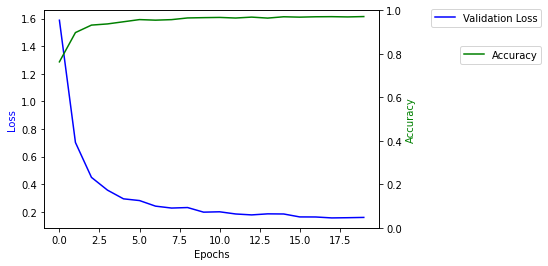

In [ ]:
plot_statistics('prepared_final', epochs=20)

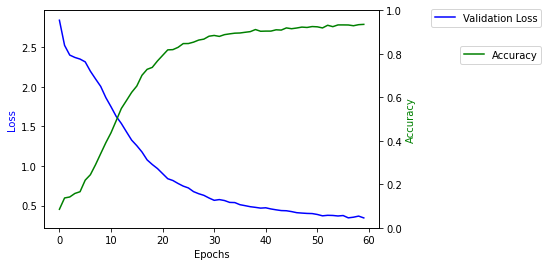

In [ ]:
plot_statistics('m1')

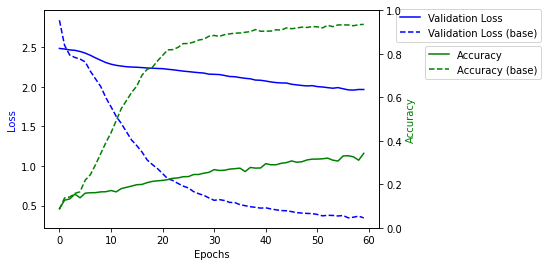

In [ ]:
plot_statistics('mcs', base = 'm1')


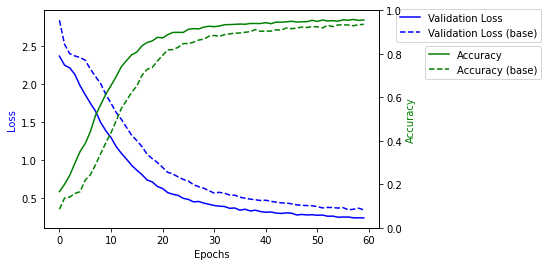

In [ ]:
plot_statistics('mcb', base = 'm1')

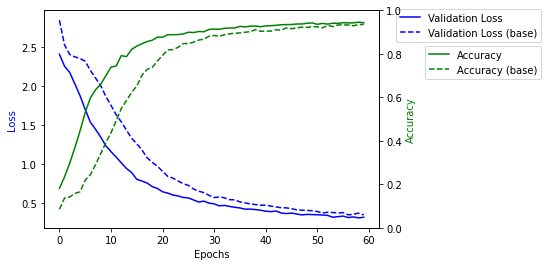

In [ ]:
plot_statistics('mls', base = 'm1')

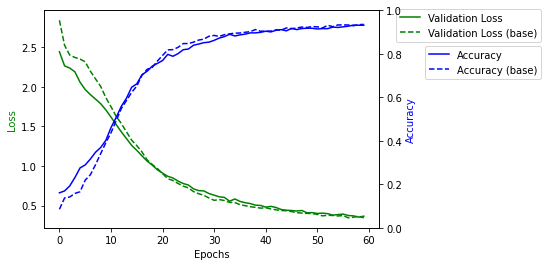

In [ ]:
plot_statistics('mlb', base = 'm1')

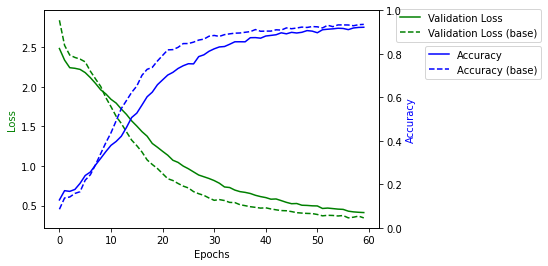

In [ ]:
plot_statistics('mlnb', base = 'm1')

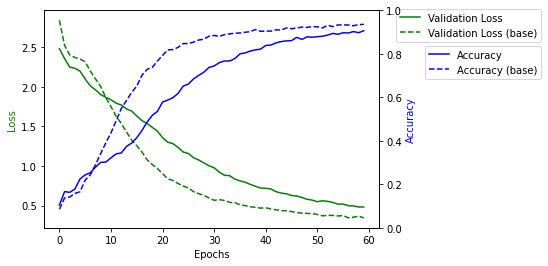

In [ ]:
plot_statistics('mlvb', base = 'm1')

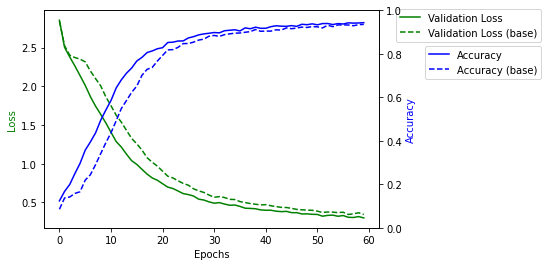

In [ ]:
plot_statistics('m1_mix', base = 'm1')

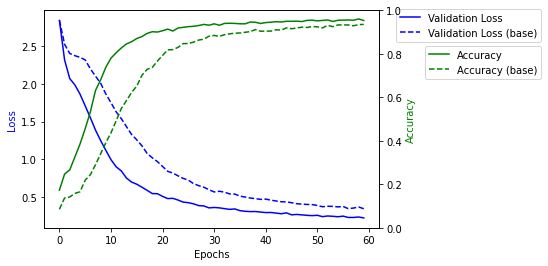

In [ ]:
plot_statistics('m1_unknown', base = 'm1')

##Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm   

labels = ['down', 'go',  'left',  'no',  'off',  'on',  'right',  'stop',  'up',  'yes',  'silence','unknown']

In [ ]:
sd = SupremeDataset()
dl_sd = torch.utils.data.DataLoader(sd, batch_size=100, shuffle=False)

In [ ]:
m_1 = m1().to('cuda')
m_1.load_state_dict(torch.load('./trained/nonpretrained_m1_0.pt'))

m_2 = m1().to('cuda')
m_2.load_state_dict(torch.load('./trained/nonpretrained_m1_mix_0.pt'))

m_3 = m1().to('cuda')
m_3.load_state_dict(torch.load('./trained/nonpretrained_m1_unknown_0.pt'))

<All keys matched successfully>

In [ ]:
m_1.eval()
y_pred = []
with torch.no_grad():
  for X,y in tqdm(dl_sd):  
    m_1.zero_grad()

    pred = m_1(X.to('cuda'))
    numb = pred.argmax(1).to('cpu')
    y_pred.append(numb)
y_pred = torch.cat(y_pred)
cm1 = confusion_matrix(sd.y, y_pred)

In [ ]:
m_2.eval()
y_pred = []
with torch.no_grad():
  for X,y in tqdm(dl_sd):  
    m_2.zero_grad()

    pred = m_2(X.to('cuda'))
    numb = pred.argmax(1).to('cpu')
    y_pred.append(numb)
y_pred = torch.cat(y_pred)
cm2 = confusion_matrix(sd.y, y_pred)

In [ ]:
m_3.eval()
y_pred = []
with torch.no_grad():
  for X,y in tqdm(dl_sd):  
    m_3.zero_grad()

    pred = m_3(X.to('cuda'))
    numb = pred.argmax(1).to('cpu')
    y_pred.append(numb)
y_pred = torch.cat(y_pred)
cm3 = confusion_matrix(sd.y, y_pred)

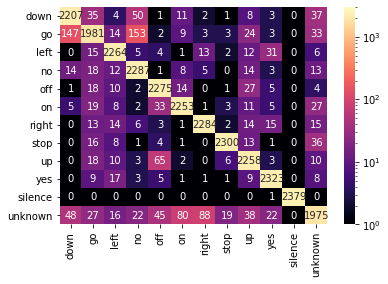

In [ ]:
ax= plt.subplot()  
import copy
my_cmap = copy.copy(plt.cm.get_cmap('magma'))
my_cmap.set_bad(my_cmap.colors[0])
sns.heatmap(cm, annot=True, fmt='g', ax=ax, norm=LogNorm(1,3000), cmap=my_cmap)
ax.xaxis.set_ticklabels(labels, rotation = 90);
ax.yaxis.set_ticklabels(labels, rotation = 0);


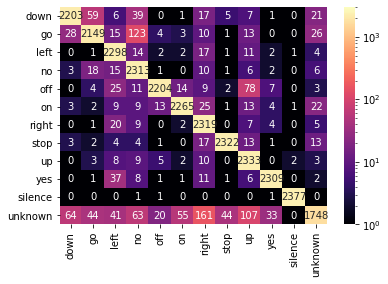

In [ ]:
ax= plt.subplot()  
import copy
my_cmap = copy.copy(plt.cm.get_cmap('magma'))
my_cmap.set_bad(my_cmap.colors[0])
sns.heatmap(cm2, annot=True, fmt='g', ax=ax, norm=LogNorm(1,3000), cmap=my_cmap)
ax.xaxis.set_ticklabels(labels, rotation = 90);
ax.yaxis.set_ticklabels(labels, rotation = 0);

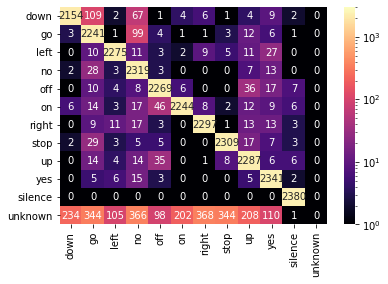

In [ ]:
ax= plt.subplot()  
import copy
my_cmap = copy.copy(plt.cm.get_cmap('magma'))
my_cmap.set_bad(my_cmap.colors[0])
sns.heatmap(cm3, annot=True, fmt='g', ax=ax, norm=LogNorm(1,3000), cmap=my_cmap)
ax.xaxis.set_ticklabels(labels, rotation = 90);
ax.yaxis.set_ticklabels(labels, rotation = 0);